# Decision trees and model architecture

In this excersice, we´ll try to predict wheter an individual crime will be solved

## Data Visualization

In [5]:
import pandas as pd

dataset = pd.read_csv('sf_crime.csv', delimiter='\t')

print(dataset.head())
print(dataset.shape)

       Category  DayOfWeek  PdDistrict  Resolution           X          Y  \
0   WEAPON LAWS          5    SOUTHERN        True -122.403405  37.775421   
1   WEAPON LAWS          5    SOUTHERN        True -122.403405  37.775421   
2      WARRANTS          1     BAYVIEW        True -122.388856  37.729981   
3  NON-CRIMINAL          2  TENDERLOIN       False -122.412971  37.785788   
4  NON-CRIMINAL          5     MISSION       False -122.419672  37.765050   

   day_of_year  time_in_hours  
0           29      11.000000  
1           29      11.000000  
2          116      14.983333  
3            5      23.833333  
4            1       0.500000  
(150431, 8)


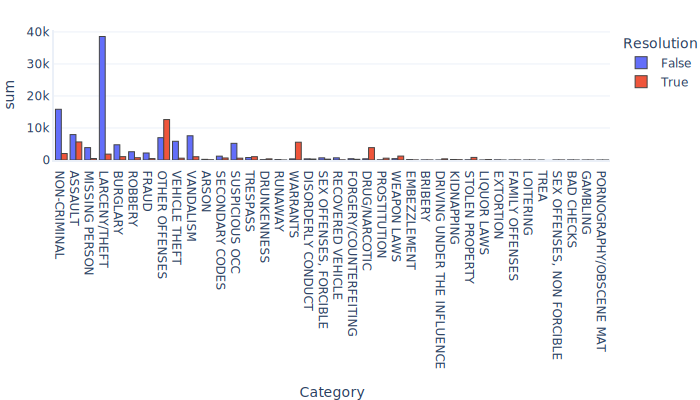

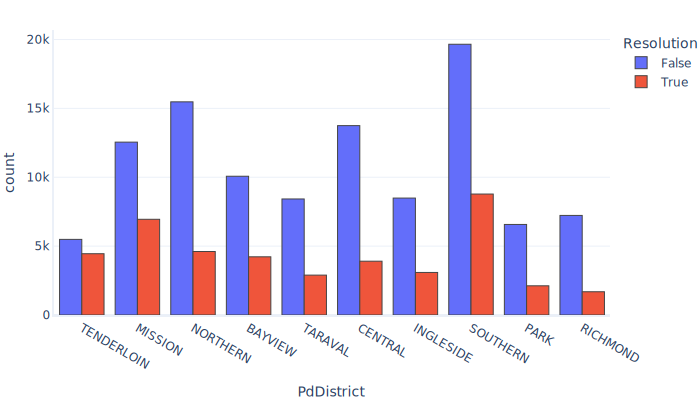

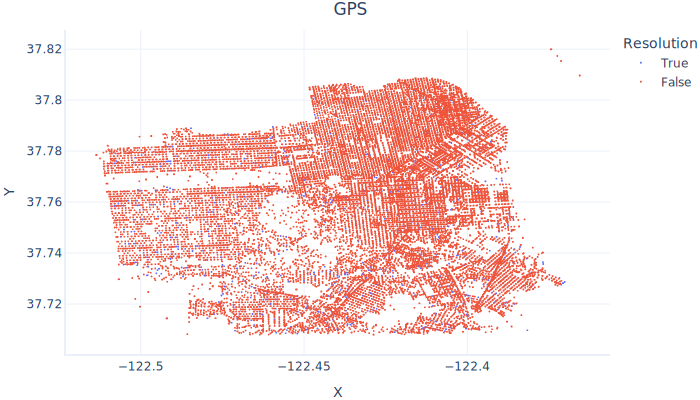

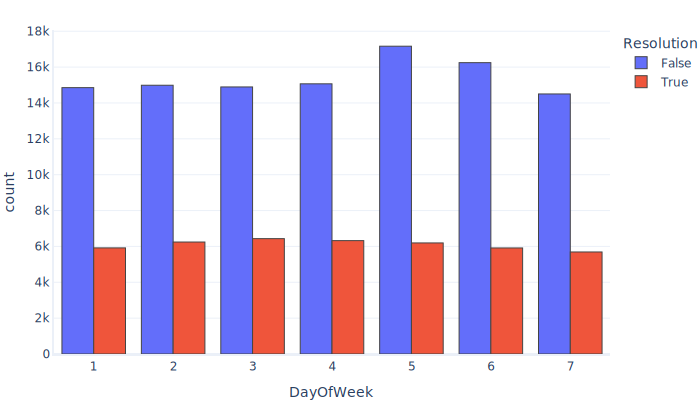

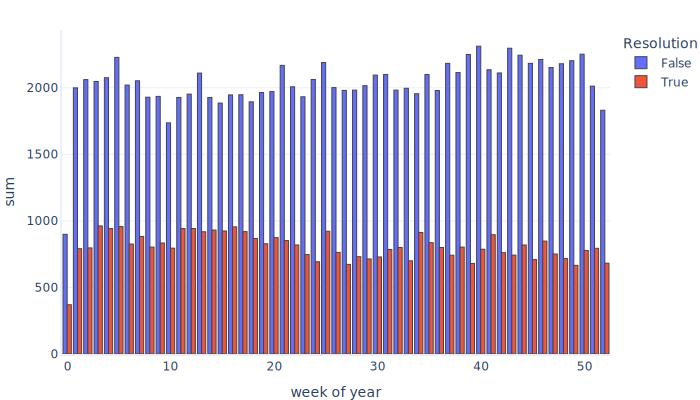

In [7]:
import graphing as gr
import numpy as np
import plotly.io as pio

pio.renderers.default = "svg"

# Crime category
gr.multiple_histogram(dataset, label_x='Category', label_group='Resolution', histfunc='sum', show=True)

# District
gr.multiple_histogram(dataset, label_x='PdDistrict', label_group='Resolution', show=True)

# Map of crimes
gr.scatter_2D(dataset, label_x='X', label_y='Y', label_colour='Resolution', title='GPS', size_multiplier=0.8, show=True)

# Day of the week
gr.multiple_histogram(dataset, label_x='DayOfWeek', label_group='Resolution', show=True)

# day of the year
# For graphing we simplify this to week or the graph becomes overwhelmed with bars
dataset["week_of_year"] = np.round(dataset.day_of_year / 7.0)
gr.multiple_histogram(dataset, 
                    label_x='week_of_year',
                    label_group='Resolution',
                    histfunc='sum', show=True)
del dataset["week_of_year"]


It always pays to inspect your data before diving in. What we can see here is that:

- Most reported crimes were not resolved in 2016

- Different police districts reported different volumes of crime

- Different police districts reported different success rates resolving crimes

- Friday and Saturday typically had more crimes than other days

- Larsony/Theft was overwhelmingly the most common crime reported

## Finalising data preparation

one-hot encoding categorical features

In [8]:
#one-hot encode categorical variables
dataset = pd.get_dummies(dataset, columns=['Category', 'PdDistrict'], drop_first=False)

print(dataset.head())

   DayOfWeek  Resolution           X          Y  day_of_year  time_in_hours  \
0          5        True -122.403405  37.775421           29      11.000000   
1          5        True -122.403405  37.775421           29      11.000000   
2          1        True -122.388856  37.729981          116      14.983333   
3          2       False -122.412971  37.785788            5      23.833333   
4          5       False -122.419672  37.765050            1       0.500000   

   Category_ARSON  Category_ASSAULT  Category_BAD CHECKS  Category_BRIBERY  \
0               0                 0                    0                 0   
1               0                 0                    0                 0   
2               0                 0                    0                 0   
3               0                 0                    0                 0   
4               0                 0                    0                 0   

   ...  PdDistrict_BAYVIEW  PdDistrict_CENTRAL  PdDistri

In [9]:
# Split into training and test sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.1, random_state=2, shuffle=True)

print('Training set size: ', train.shape)
print('Test set size: ', test.shape)

Training set size:  (135387, 54)
Test set size:  (15044, 54)


## Model assessment code

We will fit several models here, so to maximise code reuse, we will make a dedicated method that trains a model and then tests it.

Our test stage uses a metric called "balanced accuracy", which we will refer to as "accuracy" for short throughout this exercise. It is not critical that you understand this metric for these exercises, but in essence this is between `0` and `1`:
* `0` means no answers were correct
* `1` means all answers were correct

Balanced accuracy takes into account that our data set has more unresolved than resolved crimes. We will cover what this means in later learning material in this course.

In [14]:
from sklearn.metrics import balanced_accuracy_score

features = [c for c in dataset.columns if c != 'Resolution']

def fit_test_model(model):
    global features

    # Train
    model.fit(train[features], train.Resolution)

    # Assess its performance
    # - Train
    predictions = model.predict(train[features])
    train_accuracy = balanced_accuracy_score(train['Resolution'], predictions)

    # - Test
    predictions = model.predict(test[features])
    test_accuracy = balanced_accuracy_score(test['Resolution'], predictions)

    return train_accuracy, test_accuracy

## Fitting the decision tree

In [15]:
import sklearn.tree as tree

# Fit a simple tree with only 3 levels
model = tree.DecisionTreeClassifier(random_state=2, max_depth=3)
train_accuracy, test_accuracy = fit_test_model(model)

print('Train accuracy: ', train_accuracy)
print('Test accuracy: ', test_accuracy)

Train accuracy:  0.6815388711342845
Test accuracy:  0.674722862128782


In [19]:
from matplotlib import pyplot as plt

def show_tree(model):
    global features

    plot = plt.subplots(figsize=(4,4), dpi=300)[0]
    plot = tree.plot_tree(model, fontsize=3, 
                        feature_names=features, 
                        class_names=['0', '1'],
                        label='root',
                        impurity=False, 
                        filled=True)
    plt.show()

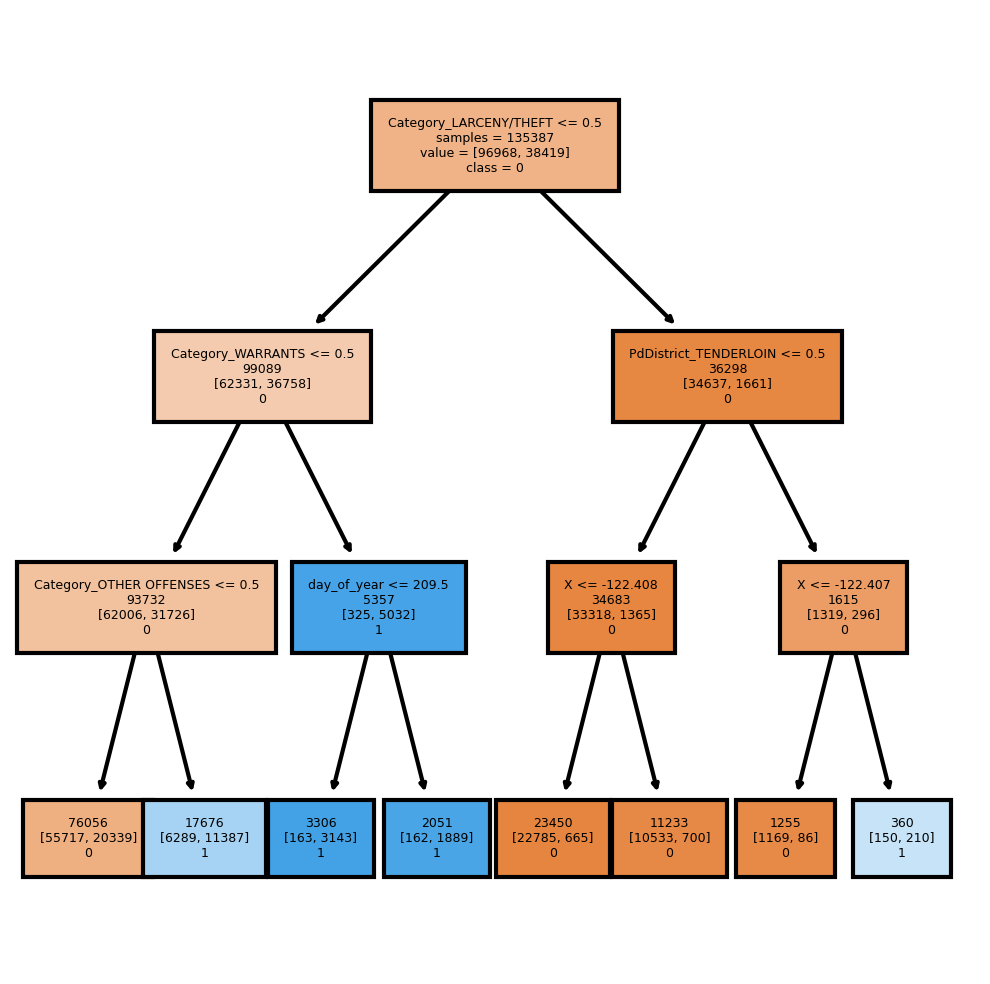

In [20]:
show_tree(model)

All of the blue colored boxes correspond to prediction that a crime would be resolved. 

Take a look at the tree to see what it thinks are important for predicting an outcome. Compare this to the graphs we made earlier. Can you see a relationship between the two?

The score we have is not bad, but the tree is pretty simple. Let's see if we can do better.

## Improving performance through architecture

We will try and improve our model's performance by changing its architecture. Let's focus on the ``maximum_depth`` parameter. 

Our previous tree was relatively simple and shallow with a ``maximum_depth = 3``. Let's see what happens if we increase it to 100:

In [21]:
# Fit a very deep tree

model = tree.DecisionTreeClassifier(random_state=1, max_depth=100)
train_accuracy, test_accuracy = fit_test_model(model)
print('Train accuracy: ', train_accuracy)
print('Test accuracy: ', test_accuracy)

Train accuracy:  0.9995864881946777
Test accuracy:  0.7767968524220694


As you can imagine, a tree with a ``maximum_depth = 100`` is big. Too big to visualize here, so let's jump straight into seeing how the new model works on our training data.

Both the training and test accuracy have increased a lot. The training, however, has increased much more. While we're happy with the improvement in test accuracy, this is a clear sign of _overfitting_.

Overfitting with decision trees becomes even more obvious when we have more typical (smaller) sized datasets. Let's re-run the previous exercise but with only 100 training samples:

In [22]:
# Shrink the training set to something more realistic
full_train = train
train = train[:100]

# Fit the same tree
model = tree.DecisionTreeClassifier(random_state=1, max_depth=100)

train_accuracy, test_accuracy = fit_test_model(model)
print('Train accuracy: ', train_accuracy)
print('Test accuracy: ', test_accuracy)

train = full_train

Train accuracy:  1.0
Test accuracy:  0.5850645895576951


The model performs badly on the test data. With reasonable sized datasets, _decision trees_ are notoriously prone to _overfitting_. In other words, they tend to fit very well to the data they're trained on, but generalize very poorly to unknown data. This gets worse the deeper the tree gets or the smaller the training set gets. Let's see if we can mitigate this.

## Pruning a tree

_Pruning_ is the process of simplifying a _decision tree_ so that it gives the best classification results while simultaneously reducing overfitting. There are two types of pruning: _pre-pruning_ and _post-pruning_. 

_Pre-pruning_ involves restricting the model during training, so that it does not grow larger than is useful. We will cover this below.

_Post-pruning_ is when we simplify the tree after training it. It does not involve the making of any design decision ahead of time, but simply optimizing the exisiting model. This is a valid technique but is quite involved, and so we do not cover it here due time constraints.

## Prepruning

We can perform pre-pruning, by generating many models, each with different ``max_depth`` parameters. For each, we recording the _balanced accuracy_ for the _test set_. To show that this is important even with quite large datasets, we will work with 10000 samples here.

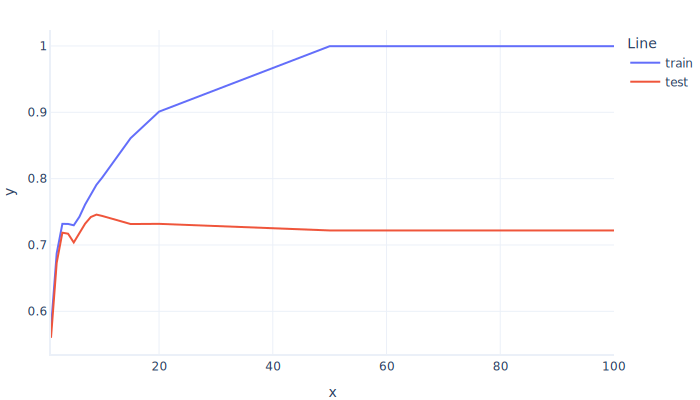

In [23]:
full_train = train
train = train[:10000]

# Loop through the values below and build a model
# each time, setting the maximum depth to that value 
max_depth_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,15, 20, 50, 100]
accuracy_trainset = []
accuracy_testset = []
for depth in max_depth_range:
    # Create and fit the model
    prune_model = tree.DecisionTreeClassifier(random_state=1, max_depth=depth)

    # Calculate and record its sensitivity
    train_accuracy, test_accuracy = fit_test_model(prune_model)
    accuracy_trainset.append(train_accuracy)
    accuracy_testset.append(test_accuracy)

# Plot the sensitivity as a function of depth  
pruned_plot = pd.DataFrame(dict(max_depth=max_depth_range, accuracy=accuracy_trainset))

fig = gr.line_2D(dict(train=accuracy_trainset, test=accuracy_testset), x_range=max_depth_range, show=True)

# Roll the training set back to the full thing
train = full_train

We can see from our plot that the best _accuracy_ is obtained for a ``max_depth`` of about 10. We are looking to simplify our tree, so we pick ``max_depth = 10`` for our final _pruned_ tree:

In [24]:
# Temporarily shrink the training set to 10000
# for this exercise to see how pruning is important
# even with moderately large datasets
full_training_set = train
train = train[:10000]


# Not-pruned
model = tree.DecisionTreeClassifier(random_state=1)
train_accuracy, test_accuracy = fit_test_model(model)
print("Unpruned Train accuracy", train_accuracy)
print("Unpruned Test accuracy", test_accuracy)


# re-fit our final tree to print out its performance
model = tree.DecisionTreeClassifier(random_state=1, max_depth=10)
train_accuracy, test_accuracy = fit_test_model(model)
print("Train accuracy", train_accuracy)
print("Test accuracy", test_accuracy)

# Roll the training set back to the full thing
train = full_training_set

Unpruned Train accuracy 0.9996434937611408
Unpruned Test accuracy 0.7219189452075965
Train accuracy 0.8016027915999302
Test accuracy 0.7437900187051387
